In [1]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
from glob import glob
import librosa
import IPython
from matplotlib import pyplot as plt
from matplotlib import colors
import simpleaudio as sa

In [2]:
def get_music_filenames(path, ext=".mp3"):
    for filen in glob(path+"/**/*"+ext):
        yield filen

def export(filename, data, sr, normalize=True):
    if normalize:
        data = data/np.max(np.abs(data))
    data = (data * (2**15-1)).astype(int).astype(np.int16)
    wavfile.write(filename, sr, data)

In [3]:
filenames = list(get_music_filenames('WTK-data'))
music0, sr = librosa.load(filenames[0])
dt = 1 / sr
sr

C:\Users\losti\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050

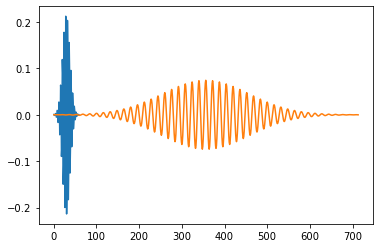

In [30]:
freq = np.array([120,10])
w = 40
sr = 160
n_scale = 7
widths = w*sr / (2*freq*np.pi)

plt.plot(np.real(signal.morlet2(widths[0]*n_scale, widths[0], w)))
plt.plot(np.real(signal.morlet2(widths[1]*n_scale, widths[1], w)))
plt.show()

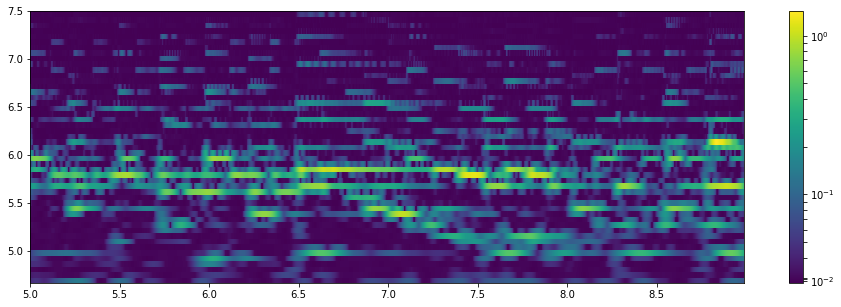

In [10]:
n0 = 5*sr

n = 22000*4
t = np.arange(n0, n0+n) / sr
w = 40.
freq = np.logspace(np.log10(110), np.log10(880*2), 4*12+1, base=10) # in Hz
widths = w*sr / (2*freq*np.pi)
cwtm = signal.cwt(music0[n0:n0+n], signal.morlet2, widths, w=w)
plt.figure(figsize=(16,5))
plt.pcolormesh(t, np.log(freq), np.abs(cwtm), cmap='viridis', shading='nearest',
               norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, base=10))
plt.colorbar()
plt.show()

In [7]:
def back_to_sound(t, cwt, freqs):
    vals = np.sin(2*np.pi*t.reshape(1,-1) * freqs.reshape(-1,1))
    return np.mean(vals * np.abs(cwt) / np.max(np.abs(cwt)), axis=0)

In [11]:
returned_sound = back_to_sound(t, cwtm, freq)
#print(returned_sound.shape)
export("restored.wav", returned_sound, sr)

In [12]:
IPython.display.Audio("restored.wav")

In [166]:
export("orig.wav", music0[n0:n0+n], sr)

In [2]:
IPython.display.Audio("orig.wav")

In [92]:
def playsound(data, sr):
    raise NotImplementedError("This doesn't work XP")
    data = (data * (2**15-1)).astype(int)
    wave_obj = sa.WaveObject(data, 1, 2, sr)
    play_obj = wave_obj.play()
    play_obj.wait_done()

In [35]:
def analyze_frequencies(sound, sr, min_hz=110, max_hz=None, n_steps=49):
    if max_hz is None:
        max_hz = min_hz * 2**((n_steps-1)/12)
    elif min_hz is None:
        min_hz = max_hz * 2**(-(n_steps-1)/12)
    
    t = np.arange(len(sound)) / sr
    w = 40.
    freq = np.logspace(np.log10(min_hz), np.log10(max_hz), 4*12+1, base=10) # in Hz
    widths = w*sr / (2*freq*np.pi)
    cwtm = signal.cwt(sound, signal.morlet2, widths, w=w)
    plt.figure(figsize=(16,5))
    plt.pcolormesh(t, np.log(freq), np.abs(cwtm), cmap='viridis', shading='nearest',
                   norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, base=10))
    plt.colorbar()
    plt.show()
    return t,freq,cwtm

In [23]:
g_scale, gsr = librosa.load("gmaj_scale.mp3")

C:\Users\losti\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


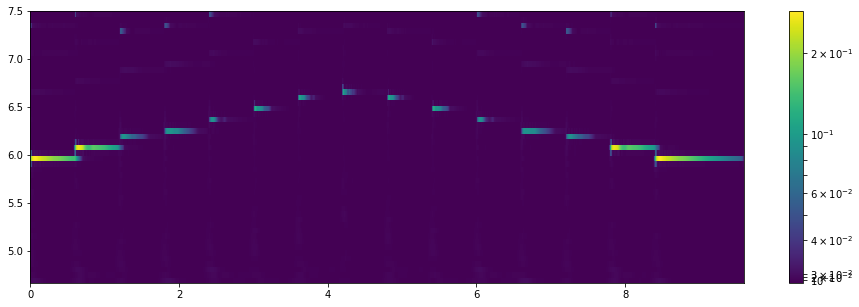

In [30]:
t, freqs, data = analyze_frequencies(g_scale, gsr)

In [32]:
export("re_scale.wav", back_to_sound(t, data, freqs), gsr)
IPython.display.Audio("re_scale.wav")

# Time for some models?

In [33]:
import cdhmm as cd

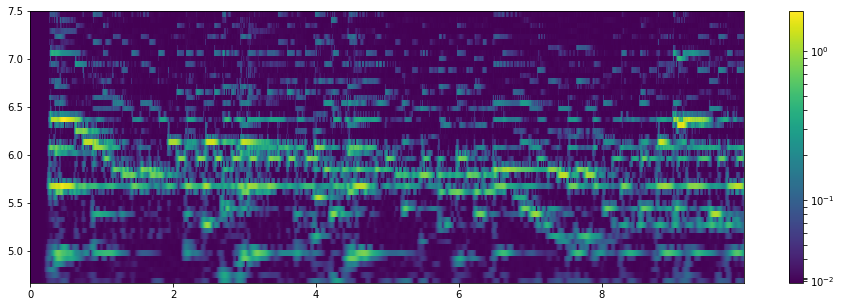

In [36]:
t,freq,cwtm = analyze_frequencies(music0[:sr*10], sr)

In [40]:
def split_into_windows(cwtm, window_ms, sr, window_func, output_dim):
    cwtm = np.abs(cwtm)
    window_size = (window_ms*sr)//1000
    n_freqs = cwtm.shape[0]
    n_windows = cwtm.shape[1] // window_size
    t = np.linspace(0,1,window_size)
    
    out = np.empty((n_windows, n_freqs, output_dim))
    
    for i in range(n_windows):
        out[i,:,:] = window_func(t, cwtm[:,i*window_size:(i+1)*window_size])
    return out

In [50]:
mean_vals = split_into_windows(cwtm, 120, sr, lambda t,x: np.mean(x, axis=1).reshape(-1,1), 1)
n_windows = mean_vals.shape[0]
mean_vals = mean_vals[:,:,0]

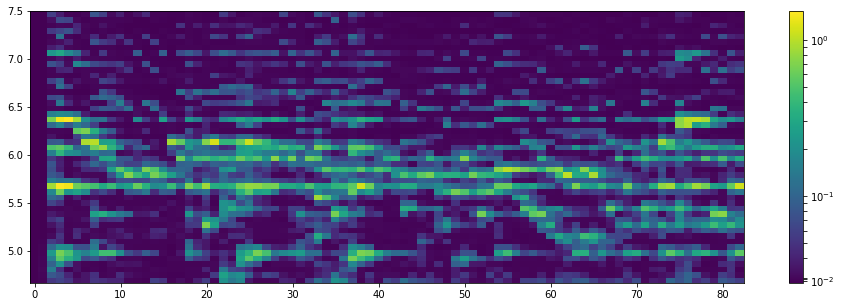

In [51]:
plt.figure(figsize=(16,5))
plt.pcolormesh(np.arange(n_windows), np.log(freq), mean_vals.T, cmap='viridis', shading='nearest',
               norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, base=10))
plt.colorbar()
plt.show()